In [30]:
# data manipulation
import pandas as pd
import numpy as np

# pre processing
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC

# metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# plotting
import matplotlib.pyplot as plt

# saving
import joblib

In [2]:
X_train = joblib.load('data/X_train_preprocessed.pkl')
X_test = joblib.load('data/X_test_preprocessed.pkl')
y_train = joblib.load('data/y_train_preprocessed.pkl')
y_test = joblib.load('data/y_test_preprocessed.pkl')

In [3]:
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

In [4]:
svc = SVC()
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [11]:
param_grid = [
    # Kernel linear
    {
        'kernel': ['linear'],
        'C': [0.01, 0.1, 1, 10, 100]
    },
    # Kernel RBF (Gaussiano)
    {
        'kernel': ['rbf'],
        'C': [0.01, 0.1, 1, 10, 100],
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1]
    },
    # Kernel polinomial
    {
        'kernel': ['poly'],
        'C': [0.01, 0.1, 1, 10, 100],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'coef0': [0.0, 0.1, 0.5, 1.0]
    },
    # Kernel sigmoide
    {
        'kernel': ['sigmoid'],
        'C': [0.01, 0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'coef0': [0.0, 0.1, 0.5, 1.0]
    }
]

In [25]:
def train_random_search(X, y, estimator, grid):
    grid_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=grid,
        cv=skf,
        scoring=scoring,
        refit='f1_macro',
        n_jobs=-1,
        return_train_score=True,
        n_iter=100, 
        verbose=1,
    )

    grid_search.fit(X, y)

    return grid_search

In [17]:
def get_results(g_search):
    results = pd.DataFrame(g_search.cv_results_)
    
    results = results[
        [
            'mean_fit_time', 'mean_score_time', 'param_kernel', 'param_C', 'param_degree',
            'param_gamma', 'param_coef0', 'mean_train_accuracy', 'mean_test_accuracy', 'rank_test_accuracy', 'mean_train_precision_macro', 
            'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 'mean_test_recall_macro', 
            'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
        ]
    ]

    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results

In [18]:
pd.set_option('display.max_columns', None)

In [26]:
random_search = train_random_search(X_train, y_train, svc, param_grid)
results = get_results(random_search)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [27]:
results.head(200)

,mean_fit_time,mean_score_time,param_kernel,param_C,param_degree,param_gamma,param_coef0,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
74,8.423897,0.224403,poly,100,4,auto,0.5,0.957253,0.858461,9,0.950334,0.746851,22,0.890247,0.700875,2,0.916880,0.718376,1
71,7.691571,0.272202,poly,0.1,4,scale,0.5,0.949219,0.858632,8,0.945096,0.748133,20,0.864984,0.686009,15,0.898855,0.708418,2
32,7.121306,0.255828,poly,0.01,4,0.1,1.0,0.949921,0.858120,10,0.945368,0.747078,21,0.867343,0.685289,17,0.900501,0.707540,3
39,11.593497,0.135616,poly,10,2,0.1,0.5,0.982208,0.840725,21,0.978007,0.711675,25,0.956662,0.701887,1,0.966933,0.705364,4
76,7.456505,0.207087,poly,100,2,0.01,0.1,0.922143,0.861699,5,0.907391,0.757789,18,0.794113,0.677837,20,0.836647,0.704389,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,5.062824,0.226858,sigmoid,0.01,NaN,0.1,1.0,0.835266,0.835266,28,0.417633,0.417633,47,0.500000,0.500000,42,0.455120,0.455120,46
33,5.075951,0.169288,poly,0.1,3,auto,0.0,0.835266,0.835266,28,0.417633,0.417633,47,0.500000,0.500000,42,0.455120,0.455120,46
31,5.752713,0.201249,poly,1,2,auto,0.5,0.835266,0.835266,28,0.417633,0.417633,47,0.500000,0.500000,42,0.455120,0.455120,46
99,3.803037,0.122403,sigmoid,0.01,NaN,0.001,0.1,0.835266,0.835266,28,0.417633,0.417633,47,0.500000,0.500000,42,0.455120,0.455120,46


In [28]:
def view_test_metrics(train_metrics: bool, filter_top_n: int, results_df: pd.DataFrame):
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]

    if filter_top_n:
        results_df = results_df.nsmallest(filter_top_n, "rank_test_f1_macro")

    param_cols = ['param_kernel', 'param_C', 'param_degree','param_gamma', 'param_coef0']
    plot_df = results_df.melt(
        id_vars=param_cols,      # keep these columns "as is"
        value_vars=metrics,      # the columns we want to "unpivot"
        var_name="metric",       # new column with the metric name
        value_name="score"       # new column with the metric value
    )

    plt.figure(figsize=(12, 8))


    for combo, group in plot_df.groupby(param_cols):
        # Sort the group by metric name (if desired)
        group = group.sort_values("metric")
        # Create a label for this parameter combination
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        
        # Separate train and test metrics using .str.startswith on the 'metric' column
        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]

        # Plot training metrics with a dashed line and an 'x' marker (with transparency)
        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     label=label_str + " (train)")
        # Plot test metrics with a solid line and an 'o' marker (with transparency)
        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     label=label_str + " (test)")

    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics")
    plt.xticks(rotation=45)
    # Adjust the legend to avoid cluttering the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()  

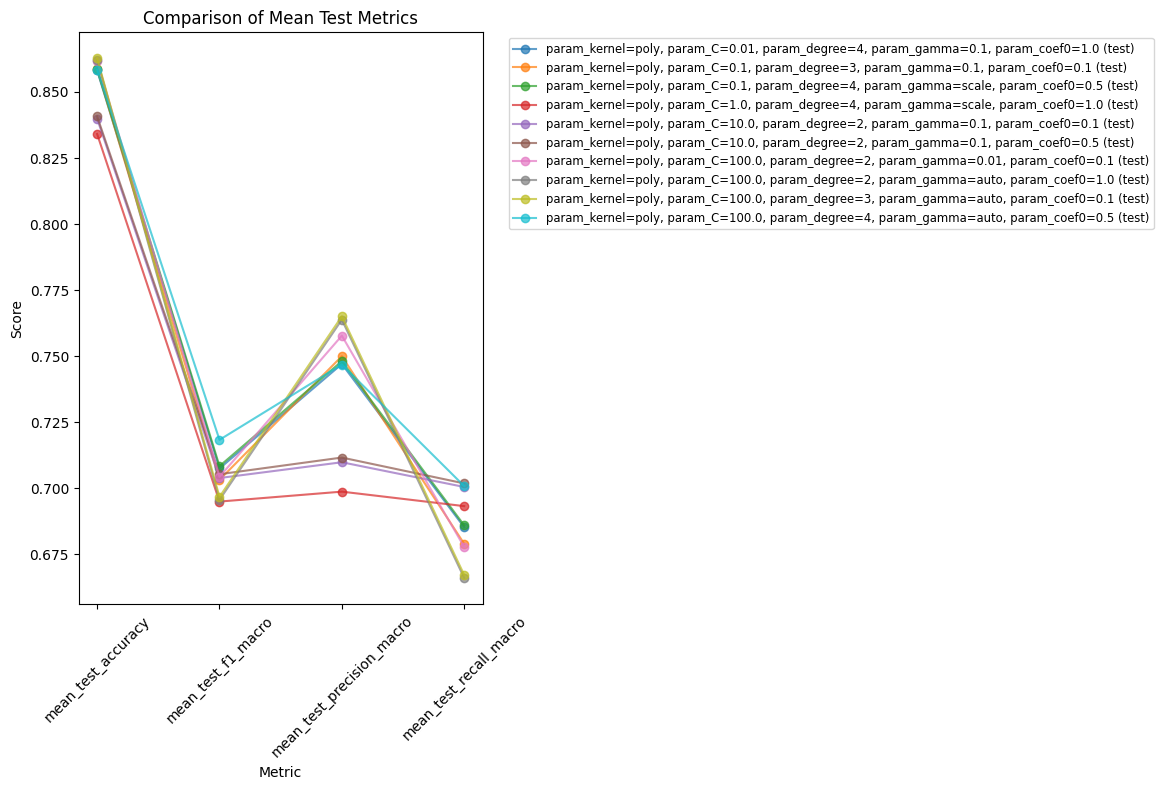

In [29]:
view_test_metrics(False, 10, results)

Como os modelos ficaram com recall e, consequentemente, f1-score baixo, isso indica que o modelo provavelmente está com bom desempenho para a classe dominante (ja que a acurácia está boa), mas não para a outra. Isso pode acontecer por conta do desbalanceamento entre as classes, então podemos tentar aplicar técnicas de balanceamento.

In [31]:
def os_smote(X, y):
    # auto faz resampling de todas as classes, menos a minoritária
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    
    return X_balanced, y_balanced

In [32]:
pipeline = Pipeline([
    ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ('svc', SVC())
])

In [33]:
param_grid = [
    # Kernel linear
    {
        'svc__kernel': ['linear'],
        'svc__C': [0.01, 0.1, 1, 10, 100]
    },
    # Kernel RBF (Gaussiano)
    {
        'svc__kernel': ['rbf'],
        'svc__C': [0.01, 0.1, 1, 10, 100],
        'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1]
    },
    # Kernel polinomial
    {
        'svc__kernel': ['poly'],
        'svc__C': [0.01, 0.1, 1, 10, 100],
        'svc__degree': [2, 3, 4],
        'svc__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'svc__coef0': [0.0, 0.1, 0.5, 1.0]
    },
    # Kernel sigmoide
    {
        'svc__kernel': ['sigmoid'],
        'svc__C': [0.01, 0.1, 1, 10, 100],
        'svc__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'svc__coef0': [0.0, 0.1, 0.5, 1.0]
    }
]

In [34]:
def get_results_pipeline(g_search):
    results = pd.DataFrame(g_search.cv_results_)
    
    results = results[
        [
            'mean_fit_time', 'mean_score_time', 'param_svc__kernel', 'param_svc__C', 'param_svc__degree',
            'param_svc__gamma', 'param_svc__coef0', 'mean_train_accuracy', 'mean_test_accuracy', 'rank_test_accuracy', 'mean_train_precision_macro', 
            'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 'mean_test_recall_macro', 
            'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
        ]
    ]

    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results

In [35]:
def view_test_metrics_pipeline(train_metrics: bool, filter_top_n: int, results_df: pd.DataFrame):
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]

    if filter_top_n:
        results_df = results_df.nsmallest(filter_top_n, "rank_test_f1_macro")

    param_cols = ['param_svc__kernel', 'param_svc__C', 'param_svc__degree', 'param_svc__gamma', 'param_svc__coef0']
    plot_df = results_df.melt(
        id_vars=param_cols,      # keep these columns "as is"
        value_vars=metrics,      # the columns we want to "unpivot"
        var_name="metric",       # new column with the metric name
        value_name="score"       # new column with the metric value
    )

    plt.figure(figsize=(12, 8))


    for combo, group in plot_df.groupby(param_cols):
        # Sort the group by metric name (if desired)
        group = group.sort_values("metric")
        # Create a label for this parameter combination
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        
        # Separate train and test metrics using .str.startswith on the 'metric' column
        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]

        # Plot training metrics with a dashed line and an 'x' marker (with transparency)
        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     label=label_str + " (train)")
        # Plot test metrics with a solid line and an 'o' marker (with transparency)
        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     label=label_str + " (test)")

    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics")
    plt.xticks(rotation=45)
    # Adjust the legend to avoid cluttering the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()  

In [37]:
def train_random_search_pipeline(X, y, estimator, grid):
    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=grid,
        cv=skf,
        scoring=scoring,
        refit='f1_macro',
        n_jobs=-1,
        return_train_score=True,
        n_iter=20, 
        verbose=1,
    )

    random_search.fit(X, y)

    return random_search

In [38]:
random_search_pipeline = train_random_search_pipeline(X_train, y_train, pipeline, param_grid)
results_pipeline = get_results_pipeline(random_search_pipeline)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [39]:
results_pipeline.head(10)

,mean_fit_time,mean_score_time,param_svc__kernel,param_svc__C,param_svc__degree,param_svc__gamma,param_svc__coef0,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
1,28.199647,0.901157,rbf,100,NaN,0.01,NaN,0.944634,0.828792,4,0.876108,0.703207,3,0.958455,0.742925,11,0.909702,0.718393,1
5,25.511449,0.708057,poly,0.1,3,0.1,0.5,0.940371,0.828453,5,0.868912,0.703260,2,0.954656,0.742723,12,0.903377,0.718245,2
3,23.439382,0.497345,poly,0.1,4,scale,1.0,0.966329,0.835783,1,0.917528,0.708602,1,0.974535,0.728402,14,0.942825,0.716746,3
10,32.549302,0.530846,poly,10,2,scale,0.1,0.954354,0.828794,3,0.893551,0.700923,4,0.966166,0.732929,13,0.924285,0.713580,4
13,26.343067,0.867892,poly,0.01,3,0.1,0.1,0.835626,0.785142,7,0.738981,0.683052,6,0.862776,0.781234,1,0.768661,0.701543,5
12,29.534766,0.651821,poly,10,4,scale,1.0,1.000000,0.831519,2,1.000000,0.693258,5,1.000000,0.686378,17,1.000000,0.688968,6
18,28.405407,0.836792,poly,1,3,auto,0.5,0.767660,0.749494,8,0.682784,0.663877,7,0.801453,0.770697,4,0.695441,0.672323,7
4,31.062726,1.264896,rbf,1,NaN,0.01,NaN,0.763681,0.746255,10,0.681698,0.663506,8,0.802257,0.772070,2,0.692787,0.670589,8
6,28.991251,1.066425,poly,100,2,0.001,0.1,0.764761,0.747108,9,0.681018,0.662759,10,0.799718,0.769687,5,0.692763,0.670351,9
17,25.435628,0.778050,poly,0.01,2,0.1,1.0,0.759399,0.744891,11,0.677130,0.662941,9,0.794707,0.771661,3,0.687299,0.669508,10


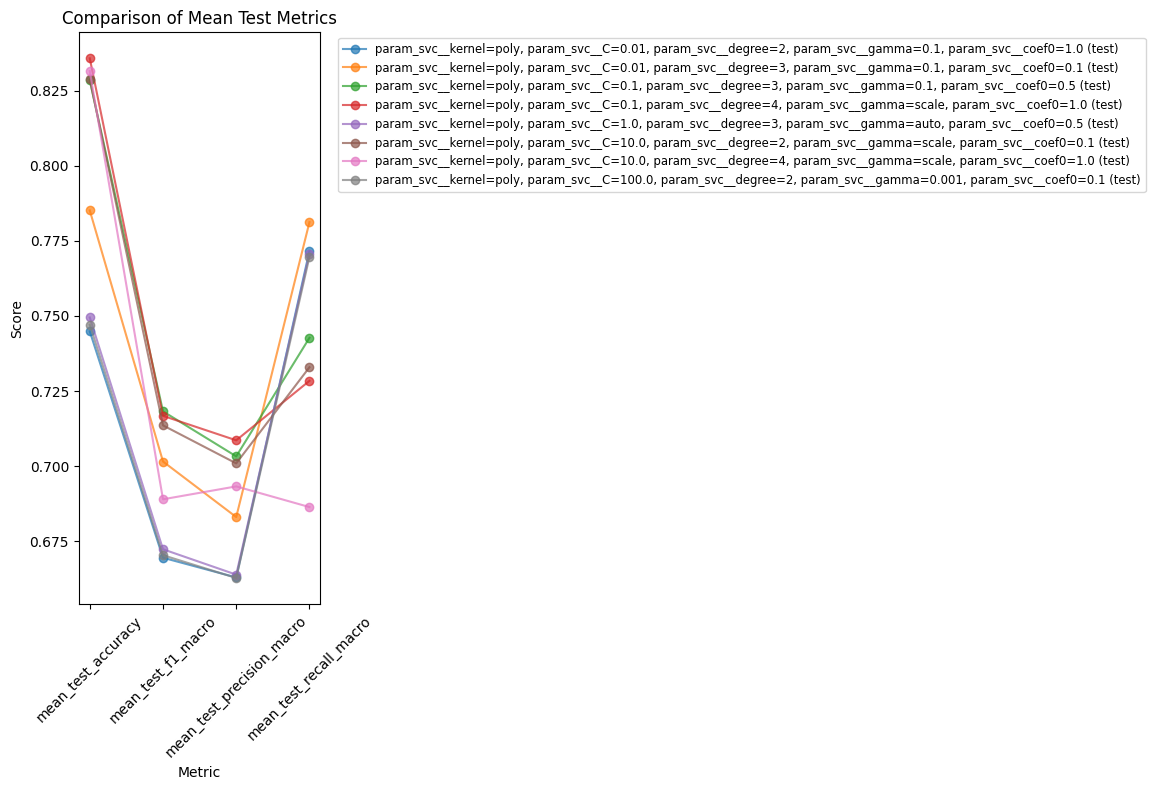

In [40]:
view_test_metrics_pipeline(False, 10, results_pipeline)

In [41]:
pipeline_SMOTE = Pipeline([
    ('oversampler', SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)),
    ('svc', SVC())
])

In [42]:
random_search_pipeline_SMOTE = train_random_search_pipeline(X_train, y_train, pipeline_SMOTE, param_grid)
results_pipeline_SMOTE = get_results_pipeline(random_search_pipeline_SMOTE)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [43]:
results_pipeline_SMOTE.head(10)

,mean_fit_time,mean_score_time,param_svc__kernel,param_svc__C,param_svc__degree,param_svc__gamma,param_svc__coef0,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
17,22.938525,0.218207,poly,10,2,scale,0.5,0.961365,0.832032,2,0.909283,0.704171,1,0.966208,0.729903,7,0.934473,0.714594,1
18,21.774503,0.210539,poly,10,2,scale,0.1,0.961005,0.830326,4,0.908751,0.701455,2,0.965485,0.727233,10,0.933856,0.711877,2
7,21.108960,0.243506,poly,10,4,0.1,0.0,1.000000,0.833393,1,1.000000,0.695913,3,1.000000,0.688745,13,1.000000,0.691611,3
12,18.946725,0.185655,poly,1,4,0.1,1.0,1.000000,0.831518,3,1.000000,0.692997,4,1.000000,0.687225,15,1.000000,0.689529,4
10,22.833108,0.179381,poly,10,3,scale,0.5,0.999754,0.827426,5,0.999300,0.687740,5,0.999806,0.688496,14,0.999553,0.687274,5
1,23.672549,0.798032,poly,1,3,auto,1.0,0.786513,0.767231,9,0.692571,0.672761,7,0.806783,0.775865,1,0.711170,0.686621,6
11,19.376061,0.173435,poly,100,3,0.1,0.1,1.000000,0.827255,6,1.000000,0.686472,6,1.000000,0.685082,16,1.000000,0.684951,7
2,45.441218,1.249365,poly,0.1,4,0.01,0.0,0.747992,0.744381,10,0.652780,0.649100,10,0.746330,0.740206,5,0.662674,0.657915,8
14,33.750129,0.822814,poly,1,2,0.001,1.0,0.729062,0.724257,13,0.659946,0.654728,8,0.774933,0.765531,2,0.659808,0.653530,9
0,53.543325,1.836932,poly,0.01,4,0.001,0.1,0.732473,0.728010,11,0.642542,0.638554,13,0.734085,0.727514,8,0.648005,0.642688,10


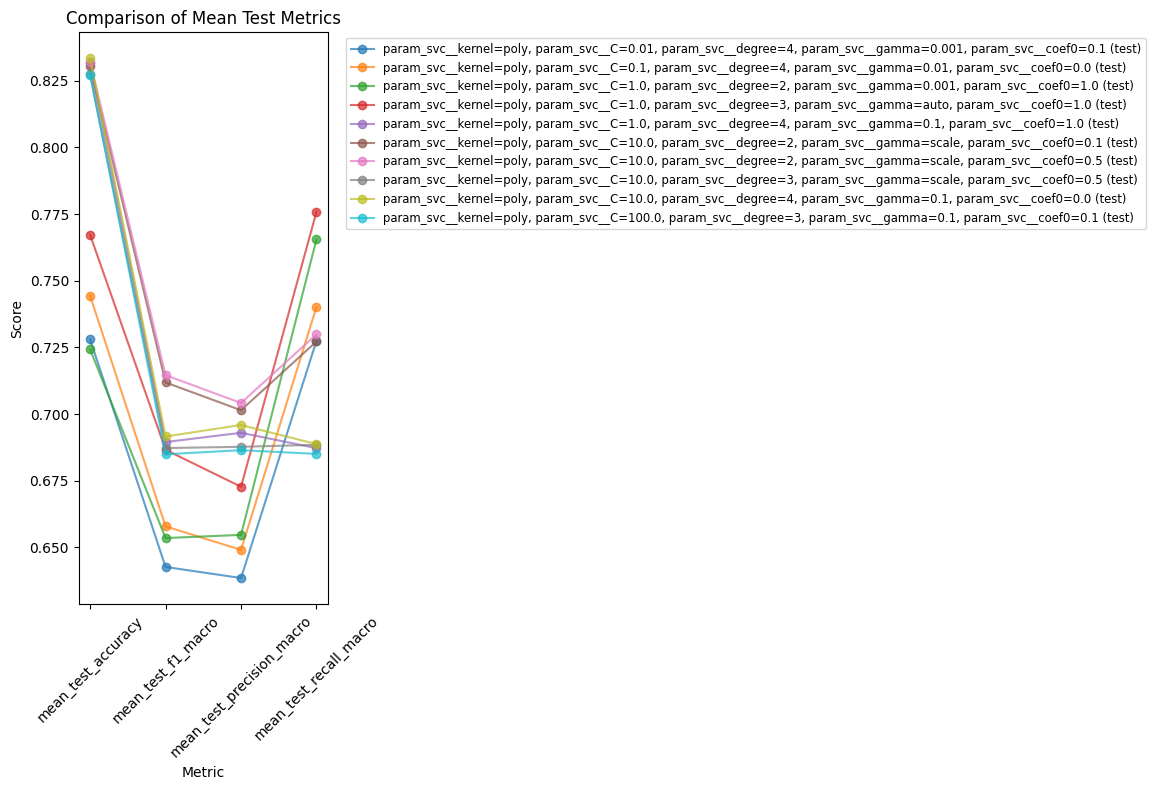

In [44]:
view_test_metrics_pipeline(False, 10, results_pipeline_SMOTE)

In [45]:
preds = cross_val_predict(random_search_pipeline.best_estimator_, X_train, y_train, cv=skf, n_jobs=-1)

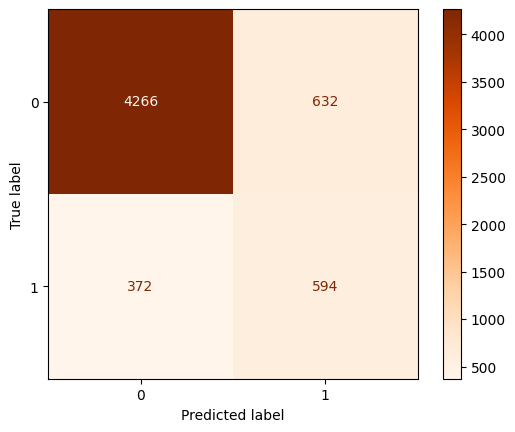

In [46]:
cm = confusion_matrix(y_train, preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=random_search_pipeline.best_estimator_.classes_)
cmd.plot(cmap=plt.cm.Oranges)
plt.show()

In [47]:
print(classification_report(y_train, preds, digits=4))

              precision    recall  f1-score   support

           0     0.9198    0.8710    0.8947      4898
           1     0.4845    0.6149    0.5420       966

    accuracy                         0.8288      5864
   macro avg     0.7021    0.7429    0.7183      5864
weighted avg     0.8481    0.8288    0.8366      5864



In [48]:
joblib.dump(random_search_pipeline.best_estimator_, 'models/svc.pkl')

['models/svc.pkl']

In [49]:
col_names = list(joblib.load('data/col_names.pkl'))

In [50]:
svc = joblib.load('models/svc.pkl')

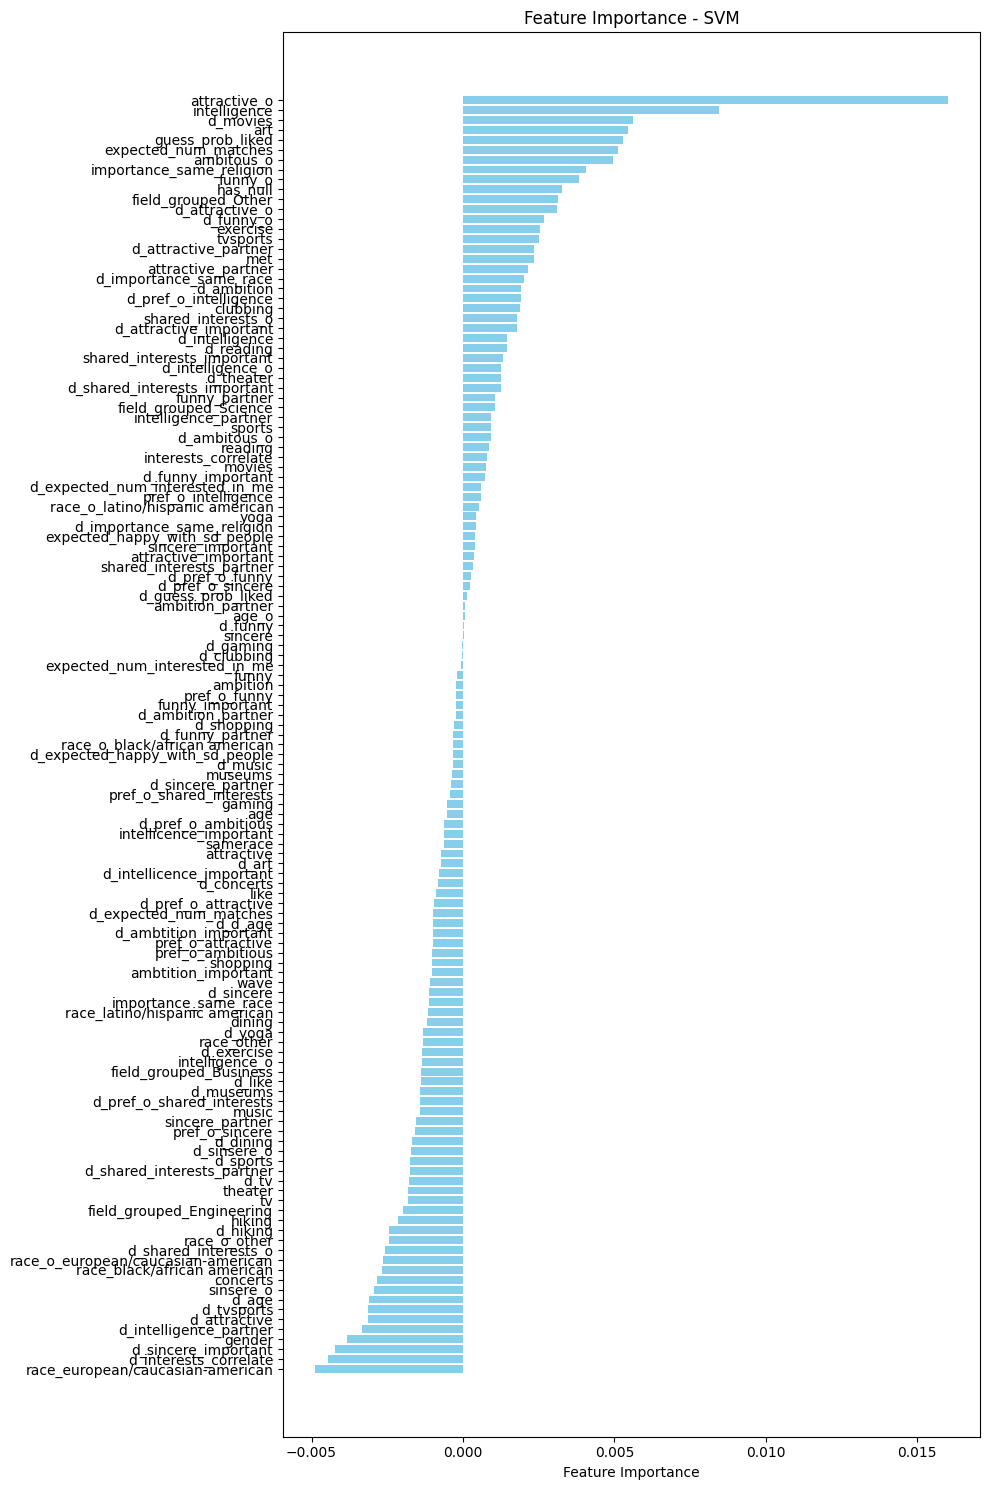

In [57]:
from sklearn.inspection import permutation_importance

result_svm = permutation_importance(
    estimator=svc,      
    X=X_test,
    y=y_test,
    n_repeats=10,
    random_state=42
)

svm_importances = result_svm.importances_mean

feature_importance_svm = pd.DataFrame(
    data=[svm_importances],
    columns=col_names
)

importance_series_svm = feature_importance_svm.iloc[0]

importance_series_sorted_svm = importance_series_svm.sort_values(ascending=True)

plt.figure(figsize=(10, 15))
plt.barh(importance_series_sorted_svm.index, importance_series_sorted_svm.values, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance - SVM')
plt.tight_layout()
plt.show()